<a href="https://colab.research.google.com/github/Paolino1994/NLP-CEIA-Fiuba/blob/main/TP4/TP4_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Consigna : Utilizar otro dataset y poner en práctica la predicción de próxima palabra

In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout

from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_teokenize de nltk
from keras.utils import pad_sequences # se utilizará para padding

In [2]:
# Descargar la carpeta de dataset
import os
import platform
if os.access('./songs_dataset', os.F_OK) is False:
    if os.access('songs_dataset.zip', os.F_OK) is False:
        if platform.system() == 'Windows':
            !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
        else:
            !wget songs_dataset.zip https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
    !unzip -q songs_dataset.zip   
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [3]:
# Posibles bandas
os.listdir("./songs_dataset/")

['jimi-hendrix.txt',
 'dj-khaled.txt',
 'r-kelly.txt',
 'prince.txt',
 'kanye.txt',
 'beatles.txt',
 'drake.txt',
 'janisjoplin.txt',
 'nirvana.txt',
 'nickelback.txt',
 'leonard-cohen.txt',
 'cake.txt',
 'notorious-big.txt',
 'Lil_Wayne.txt',
 'Kanye_West.txt',
 'bruce-springsteen.txt',
 'lady-gaga.txt',
 'bob-marley.txt',
 'adele.txt',
 'dickinson.txt',
 'radiohead.txt',
 'patti-smith.txt',
 'michael-jackson.txt',
 'paul-simon.txt',
 'nicki-minaj.txt',
 'ludacris.txt',
 'bieber.txt',
 'bob-dylan.txt',
 'dr-seuss.txt',
 'lin-manuel-miranda.txt',
 'amy-winehouse.txt',
 'kanye-west.txt',
 'bruno-mars.txt',
 'eminem.txt',
 'missy-elliott.txt',
 'alicia-keys.txt',
 'disney.txt',
 'lil-wayne.txt',
 'rihanna.txt',
 'joni-mitchell.txt',
 'bjork.txt',
 'dolly-parton.txt',
 'blink-182.txt',
 'nursery_rhymes.txt',
 'johnny-cash.txt',
 'britney-spears.txt',
 'al-green.txt',
 'lorde.txt',
 'notorious_big.txt']

In [4]:


# Continuamos con bruce springsteen
df = pd.read_csv('songs_dataset/bruce-springsteen.txt', sep='/n', header=None)
df.head()



/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,0
0,[Verse 1]
1,They come from everywhere
2,A longing to be free
3,They come to join us here
4,From sea to shining sea And they all have a dream


# Preprocesamiento

In [5]:
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus

'[Verse 1] They come from everywhere A longing to be free They come to join us here From sea to shining sea And they all have a dream As people always will To be safe and warm In that shining city on the hill Some wanna slam the door Instead of opening the gate Aw, let\'s turn this thing around Before it gets too late [Chorus] It\'s up to me and you Love can conquer hate I know this to be true That\'s what makes us great [Verse 2] Don\'t tell me a lie And sell it as a fact I\'ve been down that road before And I ain\'t goin\' back And don\'t you brag to me That you never read a book I never put my faith In a con man and his crooks I won\'t follow down that path And tempt the hands of fate Aw, let\'s turn this thing around Before it gets too late [Chorus] It\'s up to me and you Love can conquer hate I know this to be true That\'s what makes us great In the quiet of the night I lie here wide awake And I ask myself Is there a difference I can make? [Chorus] It\'s up to me and you Love can 

In [6]:
train_len=4

In [7]:
tokens=text_to_word_sequence(corpus)

In [8]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 21566


In [9]:
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [10]:
#Tokenizamos
# Proceso de tokenizacion
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Input y target

In [11]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(21562, 3)
(21562,)


In [12]:
vocab_size = len(tok.word_counts)
vocab_size

2538

In [13]:
np.bincount(y_data_int-1)

array([897, 634, 561, ...,   1,   1,   1])

In [14]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(21562, 2538)

# Train

In [15]:
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [16]:
output_size = vocab_size
output_size

2538

In [17]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 5)              12695     
                                                                 
 lstm (LSTM)                 (None, 3, 64)             17920     
                                                                 
 dropout (Dropout)           (None, 3, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 2538)              83754     
                                                                 
Total params: 149,473
Trainable params: 149,473
Non-trai

In [18]:
hist = model.fit(x_data, y_data, epochs=100, validation_split=0.2)

Epoch 1/100
540/540 [==============================] - 9s 10ms/step - loss: 6.4897 - accuracy: 0.0388 - val_loss: 6.6282 - val_accuracy: 0.0485
Epoch 2/100
540/540 [==============================] - 6s 12ms/step - loss: 6.1562 - accuracy: 0.0391 - val_loss: 6.6709 - val_accuracy: 0.0485
Epoch 3/100
540/540 [==============================] - 7s 12ms/step - loss: 6.1057 - accuracy: 0.0399 - val_loss: 6.6885 - val_accuracy: 0.0485
Epoch 4/100
540/540 [==============================] - 7s 13ms/step - loss: 6.0066 - accuracy: 0.0390 - val_loss: 6.7141 - val_accuracy: 0.0485
Epoch 5/100
540/540 [==============================] - 4s 8ms/step - loss: 5.8890 - accuracy: 0.0399 - val_loss: 6.7487 - val_accuracy: 0.0480
Epoch 6/100
540/540 [==============================] - 4s 8ms/step - loss: 5.7236 - accuracy: 0.0450 - val_loss: 6.8107 - val_accuracy: 0.0531
Epoch 7/100
540/540 [==============================] - 4s 8ms/step - loss: 5.5633 - accuracy: 0.0557 - val_loss: 6.8812 - val_accuracy: 0.

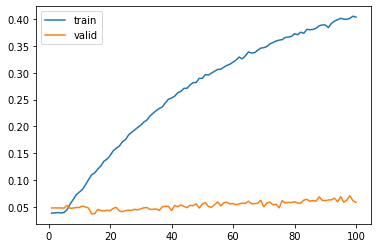

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

# Prediccion

In [22]:
def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word



In [23]:
#En la cancion "Night" tenemos la frase "Holding on for your life" en el coro
model_response("Holding on for your")

1/1 [==============================] - 1s 1s/step


'Holding on for your california'

In [24]:
# I am on fire "I can take you higher"
model_response("I can take you")

1/1 [==============================] - 0s 26ms/step


'I can take you sights'

# Generacion de secuencias

In [25]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [35]:
#Night  "Holding on for your life" 
input_text='Holding on for your'

generate_seq(model, tok, input_text, max_length=3, n_words=4)

1/1 [==============================] - 0s 25ms/step


'Holding on for your california she water the'

In [34]:
#Two faces "Sometimes mister I feel sunny and wild"
input_text='Sometimes mister I feel'

generate_seq(model, tok, input_text, max_length=3, n_words=3)

1/1 [==============================] - 0s 17ms/step


'Sometimes mister I feel i with i'

In [33]:
#Born to run "I wanna guard your dreams and visions"
input_text='I wanna guard your'

generate_seq(model, tok, input_text, max_length=3, n_words=3)

1/1 [==============================] - 0s 15ms/step


'I wanna guard your what i little'

In [32]:
#Radio Nowhere "I just want to hear some rhythm"
input_text='I just want to'

generate_seq(model, tok, input_text, max_length=3, n_words=3)

1/1 [==============================] - 0s 56ms/step


'I just want to whoa me brat'

In [36]:
#Pruebas
input_text='babe'

generate_seq(model, tok, input_text, max_length=3, n_words=10)

1/1 [==============================] - 0s 25ms/step


"babe night and you're counts clip in come minutes walls love"

In [37]:
input_text='you are'

generate_seq(model, tok, input_text, max_length=3, n_words=10)

1/1 [==============================] - 0s 16ms/step


'you are i valley love saw we mary they gotta come just'

In [38]:
input_text='feel like'

generate_seq(model, tok, input_text, max_length=3, n_words=10)

1/1 [==============================] - 0s 22ms/step


'feel like thousand up the it blast again the middle you come'

# Conclusion

En conclusion, el modelo performa bastante mal y por lo tanto con todas las pruebas que hicimos podemos notar de forma un poco mas practica que la verdad no puede llegar a hacer predicciones correctas.



Pero no por eso resulta interesante, uno espera que con un corpus mas grande  funcione mejor, pero ahi uno capaz entraria a poner letras de otros artistas, entonces habria que buscar con otro tipo de red para que pueda aprender, o mismo, generar algun tipo de ruido en nuestro corupus actual para poder maximizar el tamaño de este.